## Assignment: Using LSTMs to Classify the 20 Newsgroups Data Set
The 20 Newsgroups data set is a well known classification problem. The goal is to classify which newsgroup a particular post came from.  The 20 possible groups are:

`comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x	rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
misc.forsale
talk.politics.misc
talk.politics.guns
talk.politics.mideast
talk.religion.misc
alt.atheism
soc.religion.christian`

As you can see, some pairs of groups may be quite similar while others are very different.

The data is given as a designated training set of size 11314 and test set of size 7532.  The 20 categories are represented in roughly equal proportions, so the baseline accuracy is around 5%.

To begin, review the code below.  This will walk you through the basics of loading in the 20 newsgroups data, loading in the GloVe data, building the word embedding matrix, and building the LSTM model.

In [18]:
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

import keras

from sklearn.datasets import fetch_20newsgroups

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam

In [2]:
max_features = 20000
seq_length = 30  # How long to make our word sequences
batch_size = 32

In [3]:
# Download the 20 newsgroups data - there is already a designated "train" and "test" set
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')


In [4]:
len(newsgroups_train.data), len(newsgroups_test.data)

(11314, 7532)

In [5]:
tokenizer = Tokenizer(num_words=max_features) # num of words limited to 20000 (one hot encoded matrixes are in this dimension)
tokenizer.fit_on_texts(newsgroups_train.data)

In [6]:
sequences_train = tokenizer.texts_to_sequences(newsgroups_train.data)
sequences_test = tokenizer.texts_to_sequences(newsgroups_test.data)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) # Total number of words in this dataset is 134142


Found 134142 unique tokens.


In [8]:
x_train = pad_sequences(sequences_train, maxlen=seq_length) # converted to the sequeunce length which is 30 word for each instance
x_test = pad_sequences(sequences_test, maxlen=seq_length)


In [9]:
x_train.shape
#x_train

(11314, 30)

In [10]:
y_train = keras.utils.to_categorical(np.asarray(newsgroups_train.target)) # do the one hot encoding
y_test = keras.utils.to_categorical(np.asarray(newsgroups_test.target))

You will be using the Glove pre-trained word vectors.  Download Glove word vectors using this link:
(NOTE: this will start downloading an 822MB file)

https://nlp.stanford.edu/data/glove.6B.zip

Then unzip the file and fill your local path to the file in the code cell below.

We will use the file `glove.6B.100d.txt`

In [12]:
embeddings_index = {}
f = open('/Users/beyzakaya/Desktop/bk/Akademik/CS 566/hw3/glove.6B/glove.6B.100d.txt',  encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Let's just look at a word embedding

In [13]:
dog_vec = embeddings_index['dog']
dog_vec

array([ 0.30817  ,  0.30938  ,  0.52803  , -0.92543  , -0.73671  ,
        0.63475  ,  0.44197  ,  0.10262  , -0.09142  , -0.56607  ,
       -0.5327   ,  0.2013   ,  0.7704   , -0.13983  ,  0.13727  ,
        1.1128   ,  0.89301  , -0.17869  , -0.0019722,  0.57289  ,
        0.59479  ,  0.50428  , -0.28991  , -1.3491   ,  0.42756  ,
        1.2748   , -1.1613   , -0.41084  ,  0.042804 ,  0.54866  ,
        0.18897  ,  0.3759   ,  0.58035  ,  0.66975  ,  0.81156  ,
        0.93864  , -0.51005  , -0.070079 ,  0.82819  , -0.35346  ,
        0.21086  , -0.24412  , -0.16554  , -0.78358  , -0.48482  ,
        0.38968  , -0.86356  , -0.016391 ,  0.31984  , -0.49246  ,
       -0.069363 ,  0.018869 , -0.098286 ,  1.3126   , -0.12116  ,
       -1.2399   , -0.091429 ,  0.35294  ,  0.64645  ,  0.089642 ,
        0.70294  ,  1.1244   ,  0.38639  ,  0.52084  ,  0.98787  ,
        0.79952  , -0.34625  ,  0.14095  ,  0.80167  ,  0.20987  ,
       -0.86007  , -0.15308  ,  0.074523 ,  0.40816  ,  0.0192

In [14]:
## This creates a matrix where the $i$th row gives the word embedding for the word represented by integer $i$.
## Essentially, these will be the "weights" for the Embedding Layer
## Rather than learning the weights, we will use these ones and "freeze" the layer

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i,:len(embedding_vector)] = embedding_vector

In [15]:
embedding_matrix.shape # first dim is total number of words second dim is a embedding dim

(134143, 100)

## Assignment
### PART-1
Train the following LSTM model with the following hyper-parameters:

1. Adam optimizer with learning rate =0.001
2. Categorical cross-entropy loss for training
3. Train for 50 epochs

Evaluate the performance of your model based on the total prediction accuracy.  

## LSTM Layer
`keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- Similar in structure to the `SimpleRNN` layer
- `units` defines the dimension of the recurrent state
- `recurrent_...` refers the recurrent state aspects of the LSTM
- `kernel_...` refers to the transformations done on the input


In [35]:
word_dimension = 100  # This is the dimension of the words we are using from GloVe
model = Sequential()
model.add(Embedding(len(word_index) + 1, # embedding layer
                            word_dimension,
                            weights=[embedding_matrix],  # We set the weights to be the word vectors from GloVe
                            input_length=seq_length,
                            input_shape=(seq_length,),
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
model.add(LSTM(30, dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(20, activation='softmax')) # fully connected layer for classification with softmax

model.summary()

/Users/beyzakaya/miniforge3/envs/keras_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 30, 100)        │    13,414,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │        15,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,430,640 (51.23 MB)

 Trainable params: 16,340 (63.83 KB)

 Non-trainable params: 13,414,300 (51.17 MB)

In [36]:
# Compile the LSTM model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [37]:
# Train the LSTM model with 50 epochs and learning rate as 0.001
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=batch_size)

Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0761 - loss: 2.9707 - val_accuracy: 0.1787 - val_loss: 2.6378
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1792 - loss: 2.6369 - val_accuracy: 0.2381 - val_loss: 2.4192
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2551 - loss: 2.4204 - val_accuracy: 0.2963 - val_loss: 2.2789
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2919 - loss: 2.2838 - val_accuracy: 0.3364 - val_loss: 2.1480
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3291 - loss: 2.1605 - val_accuracy: 0.3639 - val_loss: 2.0672
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3710 - loss: 2.0542 - val_accuracy: 0.3790 - val_loss: 2.0169
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3892 - loss: 1.9882 - val_accuracy: 0.3962 - val_loss: 1.9625
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3968 - loss: 1.9565 - val_accuracy: 0.

In [38]:
# Evaluate the performance of LSTM model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.4964


#### Evaluate the performance of your model based on the total prediction accuracy.  
Test accuracy indicates that the LSTM model is predicting categories about %49 of the test dataset. We can compare the result with random category prediction as a baseline accuracy which is 5% with 20 categories.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [23]:
# Make predictions on the LSTM model to evaluate on different categories
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # probabilities to categories
y_true_classes = np.argmax(y_test, axis=1)  # correct categories

236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [24]:
categories = newsgroups_train.target_names  # 20 category names for dataset
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

# compare accury for each category
category_accuracies = {}
for category_idx, category_name in enumerate(categories):
    mask = y_true_classes == category_idx
    correct_predictions = np.sum(y_pred_classes[mask] == category_idx)
    total_predictions = np.sum(mask)
    category_accuracies[category_name] = correct_predictions / total_predictions

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.46      0.48       319
           comp.graphics       0.37      0.28      0.32       389
 comp.os.ms-windows.misc       0.33      0.29      0.31       394
comp.sys.ibm.pc.hardware       0.35      0.33      0.34       392
   comp.sys.mac.hardware       0.31      0.30      0.30       385
          comp.windows.x       0.32      0.36      0.34       395
            misc.forsale       0.49      0.58      0.53       390
               rec.autos       0.46      0.61      0.53       396
         rec.motorcycles       0.76      0.66      0.70       398
      rec.sport.baseball       0.55      0.70      0.61       397
        rec.sport.hockey       0.75      0.71      0.73       399
               sci.crypt       0.57      0.52      0.55       396
         sci.electronics       0.31      0.33      0.32       393
                 sci.med       0.53      0.56      0.54       396
         

Category: alt.atheism, Accuracy: 0.46
Category: comp.graphics, Accuracy: 0.28
Category: comp.os.ms-windows.misc, Accuracy: 0.29
Category: comp.sys.ibm.pc.hardware, Accuracy: 0.33
Category: comp.sys.mac.hardware, Accuracy: 0.30
Category: comp.windows.x, Accuracy: 0.36
Category: misc.forsale, Accuracy: 0.58
Category: rec.autos, Accuracy: 0.61
Category: rec.motorcycles, Accuracy: 0.66
Category: rec.sport.baseball, Accuracy: 0.70
Category: rec.sport.hockey, Accuracy: 0.71
Category: sci.crypt, Accuracy: 0.52
Category: sci.electronics, Accuracy: 0.33
Category: sci.med, Accuracy: 0.56
Category: sci.space, Accuracy: 0.63
Category: soc.religion.christian, Accuracy: 0.62
Category: talk.politics.guns, Accuracy: 0.50
Category: talk.politics.mideast, Accuracy: 0.69
Category: talk.politics.misc, Accuracy: 0.37
Category: talk.religion.misc, Accuracy: 0.20


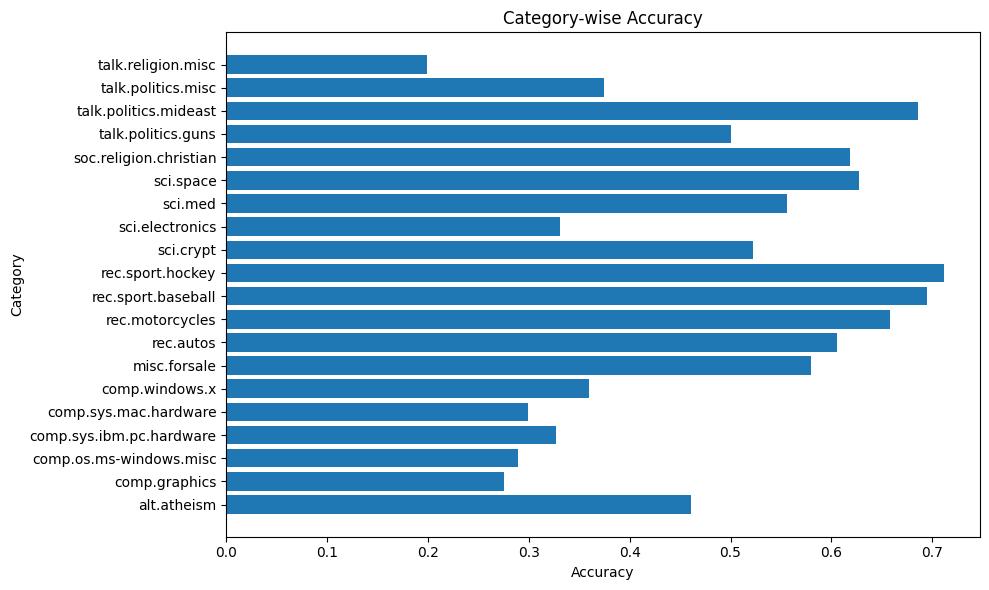

In [25]:
for category, accuracy in category_accuracies.items():
    print(f"Category: {category}, Accuracy: {accuracy:.2f}")

plt.figure(figsize=(10, 6))
plt.barh(list(category_accuracies.keys()), list(category_accuracies.values()))
plt.xlabel('Accuracy')
plt.ylabel('Category')
plt.title('Category-wise Accuracy')
plt.tight_layout()
plt.show()

Model predicts some categories better than the other categories for example in  talk.politics.misc category give 0.69 accuracy while talk.religion.misc give 0.20 accuracy so overall accuracy combines all the 20 categories as a total prediction accuracy. This indicates that different categories of the dataset perform differently with the same LSTM model.

### PART-2

1. Build a neural network with a SimpleRNN instead of an LSTM (with other dimensions and parameters the same). How does the performance compare?

2. Use the LSTM above without the pretrained word vectors (randomly initialize the weights and have them be learned during the training process).  How does the performance compare?

3. Try different sequence lengths, and dimensions for the hidden state of the LSTM.  Can you improve the model?


#### Build a neural network with a SimpleRNN

In [26]:
from keras.layers import SimpleRNN

In [30]:
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index) + 1,
                        word_dimension,
                        weights=[embedding_matrix],
                        input_shape=(seq_length,), # without this, model is in unbuilt format !
                        trainable=False))  # Freeze embeddings
rnn_model.add(SimpleRNN(30, dropout=0.25, recurrent_dropout=0.25))
rnn_model.add(Dense(20, activation='softmax'))

/Users/beyzakaya/miniforge3/envs/keras_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 30, 100)        │    13,414,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30)             │         3,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,418,850 (51.19 MB)

 Trainable params: 4,550 (17.77 KB)

 Non-trainable params: 13,414,300 (51.17 MB)

In [32]:
# Compile the SimpleRNN model
rnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=CategoricalCrossentropy(), # categorical cross entropy for multi classes 
                  metrics=['accuracy'])

In [33]:
# Train the SimpleRNN model
rnn_history = rnn_model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=50,
                            batch_size=batch_size)

Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0639 - loss: 3.1320 - val_accuracy: 0.1055 - val_loss: 2.9467
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1080 - loss: 2.9316 - val_accuracy: 0.1356 - val_loss: 2.8635
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1419 - loss: 2.8334 - val_accuracy: 0.1597 - val_loss: 2.8014
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1583 - loss: 2.8010 - val_accuracy: 0.1656 - val_loss: 2.7786
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1675 - loss: 2.7609 - val_accuracy: 0.1654 - val_loss: 2.8059
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1757 - loss: 2.7528 - val_accuracy: 0.1843 - val_loss: 2.7359
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1868 - loss: 2.7071 - val_accuracy: 0.1888 - val_loss: 2.7030
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2004 - loss: 2.6764 - val_accuracy: 0.

In [34]:
# Evaluate the performance of SimpleRNN model on test set
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(x_test, y_test, verbose=0)
print(f'SimpleRNN Test Accuracy: {rnn_test_accuracy:.4f}')

SimpleRNN Test Accuracy: 0.2350


### 1.How does the performance compare (between LSTM base model and SimpleRNN)?
SimpleRNN model uses a recurrent structure and there is no specialized gates, so it is prone to vanishing gradient problem. Also this limits the learn ability of long-term dependencies. LSTM instead introduces gates to manage memory over longer sequences. SimpleRNN model achieves an accuracy of 23.5% which is higher than the random prediction on categories as 5% so this suggest that model learned some features but lacks the manage to complexity. LSTM shows 49% accuracy in the same task so it is better in terms of capturing long term dependencies. Also SimpleRNN has 4,550 trainable parameters but LSTM has 16,340 trainable parameters so with higher number of parameters, model can capture more complex relationships.

#### Use the LSTM without pretrained word vectors

In [40]:
random_embedding_model = Sequential()
random_embedding_model.add(Embedding(len(word_index) + 1,
                                     word_dimension,
                                     input_shape=(seq_length,),
                                     trainable=True))  # train the weights instead of using stable weight vector
random_embedding_model.add(LSTM(30, dropout=0.25, recurrent_dropout=0.25))
random_embedding_model.add(Dense(20, activation='softmax'))


In [41]:
random_embedding_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 30, 100)        │    13,414,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30)             │        15,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,430,640 (51.23 MB)

 Trainable params: 13,430,640 (51.23 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Compile the embedding allowed LSTM model
random_embedding_model.compile(optimizer=Adam(learning_rate=0.001),
                               loss=CategoricalCrossentropy(),
                               metrics=['accuracy'])

In [43]:
# Train the new LSTM model
random_embedding_history = random_embedding_model.fit(x_train, y_train,
                                                      validation_data=(x_test, y_test),
                                                      epochs=50,
                                                      batch_size=batch_size)

Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.1273 - loss: 2.9015 - val_accuracy: 0.2484 - val_loss: 2.4999
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.3719 - loss: 2.1564 - val_accuracy: 0.4014 - val_loss: 2.0419
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.5948 - loss: 1.4426 - val_accuracy: 0.4377 - val_loss: 1.9183
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.7220 - loss: 0.9991 - val_accuracy: 0.4685 - val_loss: 1.8854
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.8155 - loss: 0.6971 - val_accuracy: 0.4811 - val_loss: 1.9554
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.8627 - loss: 0.5066 - val_accuracy: 0.4892 - val_loss: 2.0204
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.8948 - loss: 0.3890 - val_accuracy: 0.4914 - val_loss: 2.1105
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.9271 - loss: 0.2907 - 

In [44]:
# Evaluate the performance of new trained LSTM model with trained embeddings
random_embedding_test_loss, random_embedding_test_accuracy = random_embedding_model.evaluate(x_test, y_test, verbose=0)
print(f'LSTM Without Pre-trained Embeddings Test Accuracy: {random_embedding_test_accuracy:.4f}')

LSTM Without Pre-trained Embeddings Test Accuracy: 0.5044


#### 2. How does the performance compare?
LSTM model with random embedding creation performs better in terms of accuracy in the test data. LSTM model that trained on freezed word embeddings resulted in an accuracy of %49 and the model of LSTM that also trained the word embeddings achieve %50 accuracy in the test data. So, training word embeddings resulted in a better accuracy. With random weight initialization, weights also can be trainable so model can capture relations inside the text with compare to weights are not trainable case. In trainable weights model, there are 13,430,640 number of trainable parameters in total for the model but in non trainable weights model there are 16,340 total number of parameters. Given trainable argument as True means that at each iteration while training model can also learn the weights (as embeddings) so it can capture relationships more accurate.

#### Try different sequence lengths, and dimensions for the hidden state of the LSTM. 

In [45]:
seq_length_combined = 100
hidden_units_combined = 128

In [46]:
# Update the input data
x_train_combined = pad_sequences(sequences_train, maxlen=seq_length_combined) # for new sequence length, we need to pad the train and test sequences pad as sequence length change.
x_test_combined = pad_sequences(sequences_test, maxlen=seq_length_combined)

In [47]:
combined_model = Sequential()
combined_model.add(Embedding(len(word_index) + 1,
                              word_dimension,
                              input_shape=(seq_length,),
                              trainable=True)) 
combined_model.add(LSTM(hidden_units_combined, dropout=0.25, recurrent_dropout=0.25))
combined_model.add(Dense(20, activation='softmax'))

/Users/beyzakaya/miniforge3/envs/keras_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
combined_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 30, 100)        │    13,414,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,534,128 (51.63 MB)

 Trainable params: 13,534,128 (51.63 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compile and train
combined_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss=CategoricalCrossentropy(),
                       metrics=['accuracy'])

In [50]:
combined_history = combined_model.fit(x_train_combined, y_train,
                                      validation_data=(x_test_combined, y_test),
                                      epochs=50,
                                      batch_size=batch_size)

Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 57s 156ms/step - accuracy: 0.1170 - loss: 2.8404 - val_accuracy: 0.2791 - val_loss: 2.3488
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 98s 276ms/step - accuracy: 0.3715 - loss: 2.0752 - val_accuracy: 0.3789 - val_loss: 1.9662
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 83s 233ms/step - accuracy: 0.5575 - loss: 1.4192 - val_accuracy: 0.4456 - val_loss: 1.7875
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 87s 244ms/step - accuracy: 0.7006 - loss: 0.9567 - val_accuracy: 0.4866 - val_loss: 1.8073
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 111s 310ms/step - accuracy: 0.7875 - loss: 0.7070 - val_accuracy: 0.4887 - val_loss: 1.9036
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 65s 184ms/step - accuracy: 0.8516 - loss: 0.5141 - val_accuracy: 0.5235 - val_loss: 1.8502
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 86s 242ms/step - accuracy: 0.8956 - loss: 0.3561 - val_accuracy: 0.5106 - val_loss: 2.0030
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 62s 175ms/step - accuracy: 0.9257 - loss: 

In [51]:
combined_test_loss, combined_test_accuracy = combined_model.evaluate(x_test_combined, y_test, verbose=0)
print(f'LSTM with Seq Length {seq_length_combined} and Hidden Units {hidden_units_combined} Test Accuracy: {combined_test_accuracy:.4f}')

LSTM with Seq Length 100 and Hidden Units 128 Test Accuracy: 0.5951


#### 3. Try different sequence lengths, and dimensions for the hidden state of the LSTM.  Can you improve the model?
With different settings of which sequence lenght as 1000 and hidden units as 128, trained LSTM model resulted in a better accuracy in the same test data. Test accuracy of different settings is %59 and the other versions get accuracy of %49, %23, and %50. So trying different settings in the LSTM model performed best between four versions. Changing hidden dimension in the LSTM model allows the gate output dimension has more dimension so it can learn relationships more accurately. Additionaly, changing the sequence length with higher value can capture the correlations inside the texts between them so it gives the best performance overall in all the models.